In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime, timedelta, timezone
import traceback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, TimeDistributed, Lambda, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Lambda, LSTM, Dense
from keras.models import Model
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("C:\\Users\\nws71\\Downloads\\seoul_citydata_2 (5).csv")
pd.set_option('display.max_columns', 100)

In [3]:
df['PPLTN_TIME'] = pd.to_datetime(df['PPLTN_TIME'])
df.loc[:, 'SKY_STTS'] = df['SKY_STTS'].replace({'맑음': 3, '구름많음': 2, '흐림': 1})
df.loc[:, 'AREA_CONGEST_LVL'] = df['AREA_CONGEST_LVL'].replace({'여유': 1, '보통': 2, '약간 붐빔': 3, '붐빔': 4})

In [4]:
# Replace -999 with NaN
df['PRECPT_TYPE'] = df['PRECPT_TYPE'].replace('-999', np.nan)

# Verify the unique values
df['PRECPT_TYPE'].unique()

df = df.dropna(subset=['PRECPT_TYPE'])

# Map 'None' to 0 and 'non' to 1
df['PRECPT_TYPE'] = df['PRECPT_TYPE'].map({'없음': 0, '비': 1}).astype('category')

In [5]:
places = ['강남 MICE 관광특구',
 '동대문 관광특구',
 '명동 관광특구',
 '이태원 관광특구',
 '잠실 관광특구',
 '종로·청계 관광특구',
 '홍대 관광특구',
 '경복궁·서촌마을',
 '광화문·덕수궁',
 '창덕궁·종묘',
 '가산디지털단지역',
 '강남역',
 '건대입구역',
 '고속터미널역',
 '교대역',
 '구로디지털단지역',
 '서울역',
 '선릉역',
 '신도림역',
 '신림역',
 '신촌·이대역',
 '역삼역',
 '연신내역',
 '용산역',
 '왕십리역',
 'DMC(디지털미디어시티)',
 '창동 신경제 중심지',
 '노량진',
 '낙산공원·이화마을',
 '북촌한옥마을',
 '가로수길',
 '성수카페거리',
 '수유리 먹자골목',
 '쌍문동 맛집거리',
 '압구정로데오거리',
 '여의도',
 '영등포 타임스퀘어',
 '인사동·익선동',
 '국립중앙박물관·용산가족공원',
 '남산공원',
 '뚝섬한강공원',
 '망원한강공원',
 '반포한강공원',
 '북서울꿈의숲',
 '서울대공원',
 '서울숲공원',
 '월드컵공원',
 '이촌한강공원',
 '잠실종합운동장',
 '잠실한강공원']

In [6]:
df = df[['AREA_NM', 'AREA_CONGEST_LVL', 'AREA_PPLTN_MIN', 'AREA_PPLTN_MAX', 'PRECPT_TYPE','PPLTN_TIME']]
#, 'PPLTN_RATE_0',	'PPLTN_RATE_10',	
# 'PPLTN_RATE_20',	'PPLTN_RATE_30',	'PPLTN_RATE_40',	'PPLTN_RATE_50',	'PPLTN_RATE_60',	'PPLTN_RATE_70'

In [7]:
spot = {}
for place in places:
    spot[place] = df[df['AREA_NM'] == place]
    del spot[place]['AREA_NM'] 

In [8]:
spot['여의도'].set_index('PPLTN_TIME', inplace=True)
new_index = pd.date_range(start=spot['여의도'].index.min(), end=spot['여의도'].index.max(), freq='5min')
spot['여의도'] = spot['여의도'].reindex(new_index)

spot['여의도']['AREA_CONGEST_LVL'] = spot['여의도']['AREA_CONGEST_LVL'].interpolate(method='linear').round()
spot['여의도']['AREA_PPLTN_MIN'] = spot['여의도']['AREA_PPLTN_MIN'].interpolate(method='linear').round()
spot['여의도']['AREA_PPLTN_MAX'] = spot['여의도']['AREA_PPLTN_MAX'].interpolate(method='linear').round()
spot['여의도']['PRECPT_TYPE'].fillna(method='ffill', inplace=True) # Forward fill

spot['여의도']['PRECPT_TYPE'].astype('category')

2023-04-17 16:20:00    0
2023-04-17 16:25:00    0
2023-04-17 16:30:00    0
2023-04-17 16:35:00    0
2023-04-17 16:40:00    0
                      ..
2023-05-15 22:45:00    0
2023-05-15 22:50:00    0
2023-05-15 22:55:00    0
2023-05-15 23:00:00    0
2023-05-15 23:05:00    0
Freq: 5T, Name: PRECPT_TYPE, Length: 8146, dtype: category
Categories (2, int64): [0, 1]

In [9]:
# PPLTN_TIME 인덱스 -> 칼럼
spot['여의도'] = spot['여의도'].reset_index().rename(columns={'index': 'PPLTN_TIME'})

In [10]:
data = spot['여의도']

In [11]:
# Define holidays
holidays = [pd.Timestamp('2023-05-01').date(), pd.Timestamp('2023-05-05').date()]

In [12]:
data['day_of_week'] = data['PPLTN_TIME'].dt.dayofweek
data['is_holiday'] = data['PPLTN_TIME'].dt.date.isin(holidays).astype(int)

In [13]:
data[data['PPLTN_TIME'].dt.date == pd.to_datetime('2023-05-05').date()]

,PPLTN_TIME,AREA_CONGEST_LVL,AREA_PPLTN_MIN,AREA_PPLTN_MAX,PRECPT_TYPE,day_of_week,is_holiday
4988,2023-05-05 00:00:00,1.0,24000.0,26000.0,0,4,1
4989,2023-05-05 00:05:00,1.0,24000.0,26000.0,0,4,1
4990,2023-05-05 00:10:00,1.0,24000.0,26000.0,0,4,1
4991,2023-05-05 00:15:00,1.0,24000.0,26000.0,0,4,1
4992,2023-05-05 00:20:00,1.0,24000.0,26000.0,0,4,1
...,...,...,...,...,...,...,...
5271,2023-05-05 23:35:00,1.0,22000.0,24000.0,0,4,1
5272,2023-05-05 23:40:00,1.0,20000.0,22000.0,0,4,1
5273,2023-05-05 23:45:00,1.0,20000.0,22000.0,0,4,1
5274,2023-05-05 23:50:00,1.0,20000.0,22000.0,0,4,1


In [14]:
data.set_index('PPLTN_TIME', inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8146 entries, 2023-04-17 16:20:00 to 2023-05-15 23:05:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   AREA_CONGEST_LVL  8146 non-null   float64 
 1   AREA_PPLTN_MIN    8146 non-null   float64 
 2   AREA_PPLTN_MAX    8146 non-null   float64 
 3   PRECPT_TYPE       8146 non-null   category
 4   day_of_week       8146 non-null   int64   
 5   is_holiday        8146 non-null   int32   
dtypes: category(1), float64(3), int32(1), int64(1)
memory usage: 358.1 KB


In [16]:
# Step 4: One-hot encoding
data = pd.get_dummies(data, columns=['PRECPT_TYPE', 'day_of_week', 'is_holiday'])

In [17]:
# Split the preprocessed data into features and target
x = data.drop(['AREA_CONGEST_LVL','AREA_PPLTN_MIN', 'AREA_PPLTN_MAX'], axis=1)
y = data[['AREA_CONGEST_LVL', 'AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']] #'AREA_CONGEST_LVL', 

In [18]:
x.shape

(8146, 11)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [26]:
# Instantiate the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
# StandardScaler()
# MinMaxScaler()
# MinMaxScaler(feature_range=(-1, 1))
# Apply the same scaler to the population columns
y_train[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']] = scaler.fit_transform(y_train[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']])
y_test[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']] = scaler.transform(y_test[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']])

In [27]:
print(y_train[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']].max(),
y_train[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']].min())

AREA_PPLTN_MIN    1.0
AREA_PPLTN_MAX    1.0
dtype: float64 AREA_PPLTN_MIN   -1.0
AREA_PPLTN_MAX   -1.0
dtype: float64


In [28]:
print(y_test[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']].max(),
y_test[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']].min())

AREA_PPLTN_MIN    0.798658
AREA_PPLTN_MAX    0.802632
dtype: float64 AREA_PPLTN_MIN   -1.0
AREA_PPLTN_MAX   -1.0
dtype: float64


# AREA_PPLTN_MIN, AREA_PPLTN_MAX 정규분포 여부 확인
## [정규분포가 아닐경우 표준화 X]

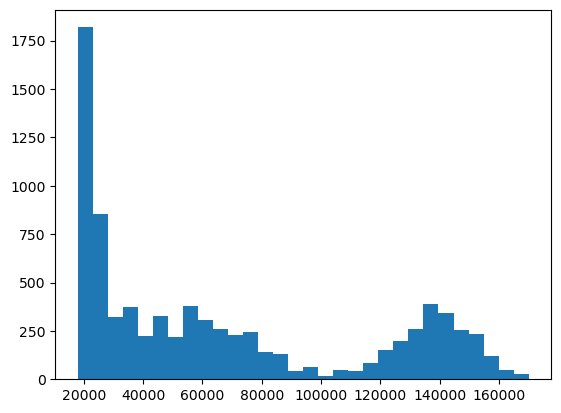

In [29]:
# 히스토그램: 히스토그램은 값을 빈으로 그룹화하고 각 빈의 빈도 또는 관찰 횟수는 분포의 스냅샷을 제공
plt.hist(y['AREA_PPLTN_MAX'], bins=30)
plt.show()

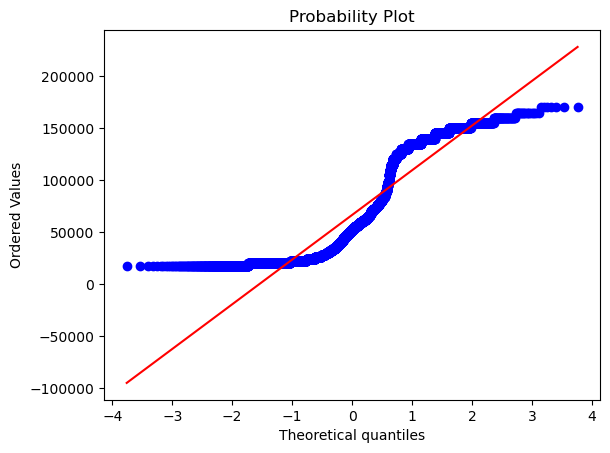

In [30]:
# QQ-Plot: QQ 플롯 또는 quantile-quantile 플롯은 주어진 샘플과 정규 분포 간의 상관 관계를 그린다.
import scipy.stats as stats

stats.probplot(y['AREA_PPLTN_MAX'], dist="norm", plot=plt)
plt.show()

In [31]:
# Shapiro-Wilk 테스트: Shapiro-Wilk 테스트는 데이터 샘플을 평가하고 데이터가 가우스 분포에서 추출된 가능성을 정량화합니다.
from scipy.stats import shapiro

stat, p = shapiro(y['AREA_PPLTN_MIN'])
print('Statistics=%.3f, p=%f' % (stat, p))
# p-value: 0.000000 -> not normally distributed

Statistics=0.853, p=0.000000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


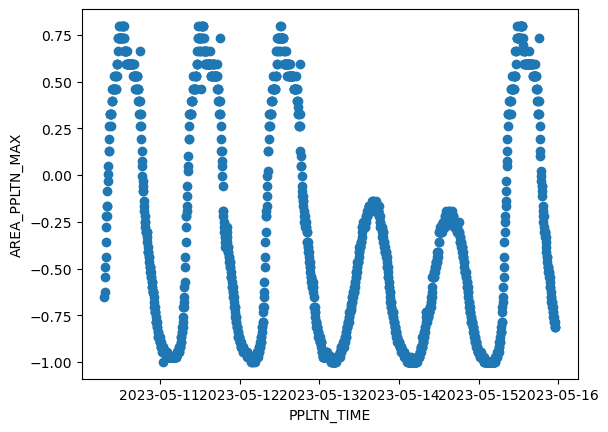

In [32]:
plt.scatter(y_test.index.values, y_test['AREA_PPLTN_MIN'])
plt.xlabel('PPLTN_TIME')
plt.ylabel('AREA_PPLTN_MAX')

plt.show()

# MinMaxScaler(feature_range=(-1, 1))
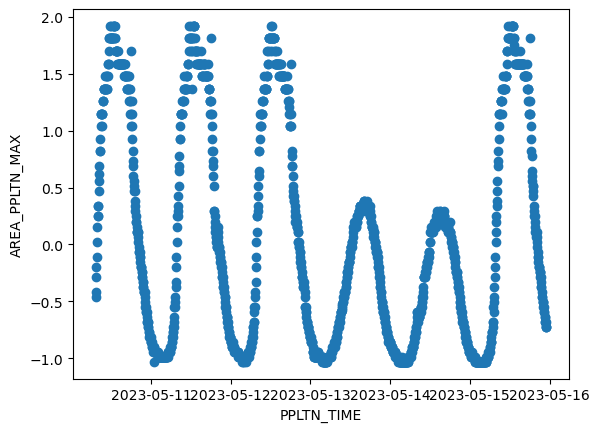

In [33]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [34]:
x_train.shape, x_val.shape, x_test.shape

((5212, 11), (1304, 11), (1630, 11))

In [35]:
y_train.shape, y_val.shape, y_test.shape

((5212, 3), (1304, 3), (1630, 3))

In [36]:
# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_val = x_val.values.reshape((x_val.shape[0], 1, x_val.shape[1]))

In [37]:
# Define a custom activation function
def mixed_activation(x):
    ordinal_output, continuous_outputs = x[:, :1], x[:, 1:]
    ordinal_output = K.sigmoid(ordinal_output) * 4  # Scale sigmoid activation to range 0-4
    continuous_outputs = K.elu(continuous_outputs)  # Exponential linear unit (ELU) activation
    return K.concatenate([ordinal_output, continuous_outputs], axis=-1)

# Add the custom activation function
# model.add(Lambda(mixed_activation))

In [43]:
def model_build():
        model = keras.Sequential([
        layers.LSTM(64),
        layers.Dense(3)
    #     Lambda(mixed_activation)
    ])
        return model
        

In [39]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [40]:
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [ ]:
model.summary()

In [41]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 16, validation_data=(x_val, y_val))

Epoch 1/30
326/326 [==============================] - 5s 7ms/step - loss: 0.6218 - mae: 0.6148 - val_loss: 0.3655 - val_mae: 0.4591
Epoch 2/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4942 - mae: 0.5647 - val_loss: 0.3705 - val_mae: 0.4543
Epoch 3/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4946 - mae: 0.5647 - val_loss: 0.3669 - val_mae: 0.4499
Epoch 4/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4939 - mae: 0.5640 - val_loss: 0.3613 - val_mae: 0.4425
Epoch 5/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4937 - mae: 0.5634 - val_loss: 0.3659 - val_mae: 0.4487
Epoch 6/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4937 - mae: 0.5631 - val_loss: 0.3649 - val_mae: 0.4467
Epoch 7/30
326/326 [==============================] - 1s 4ms/step - loss: 0.4937 - mae: 0.5636 - val_loss: 0.3694 - val_mae: 0.4551
Epoch 8/30
326/326 [==============================] - 1s 4ms/step - loss: 0.

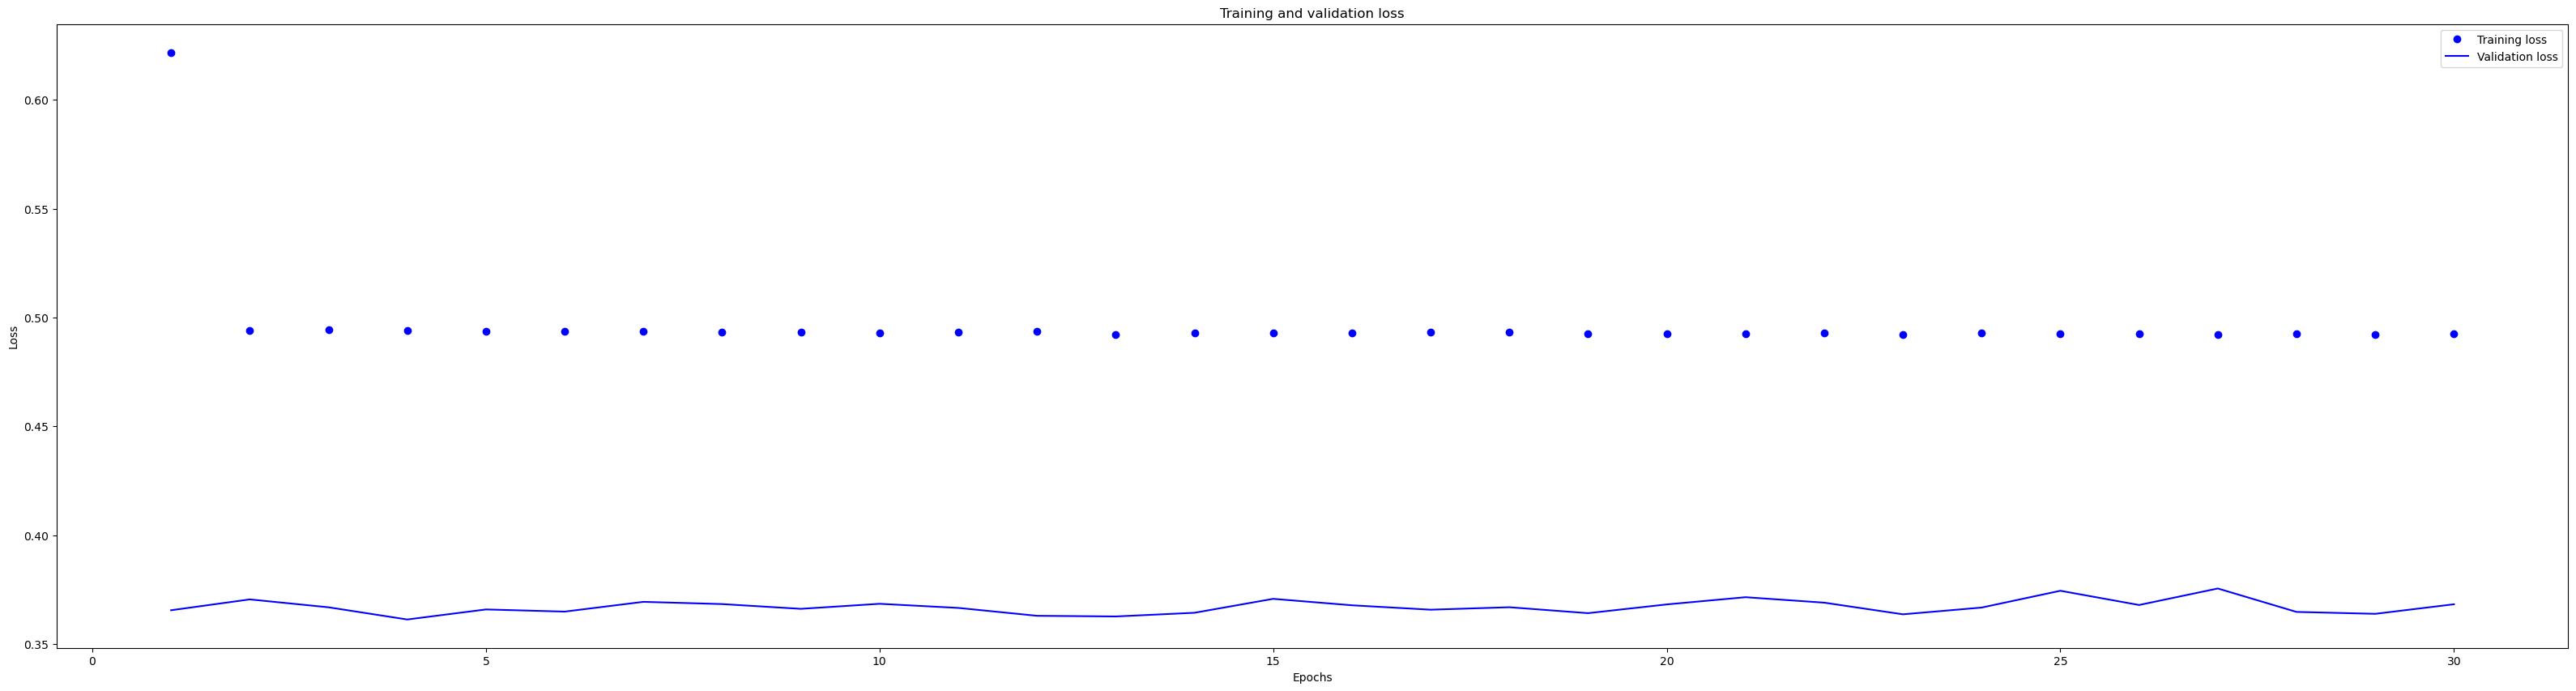

In [44]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(40,10))
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

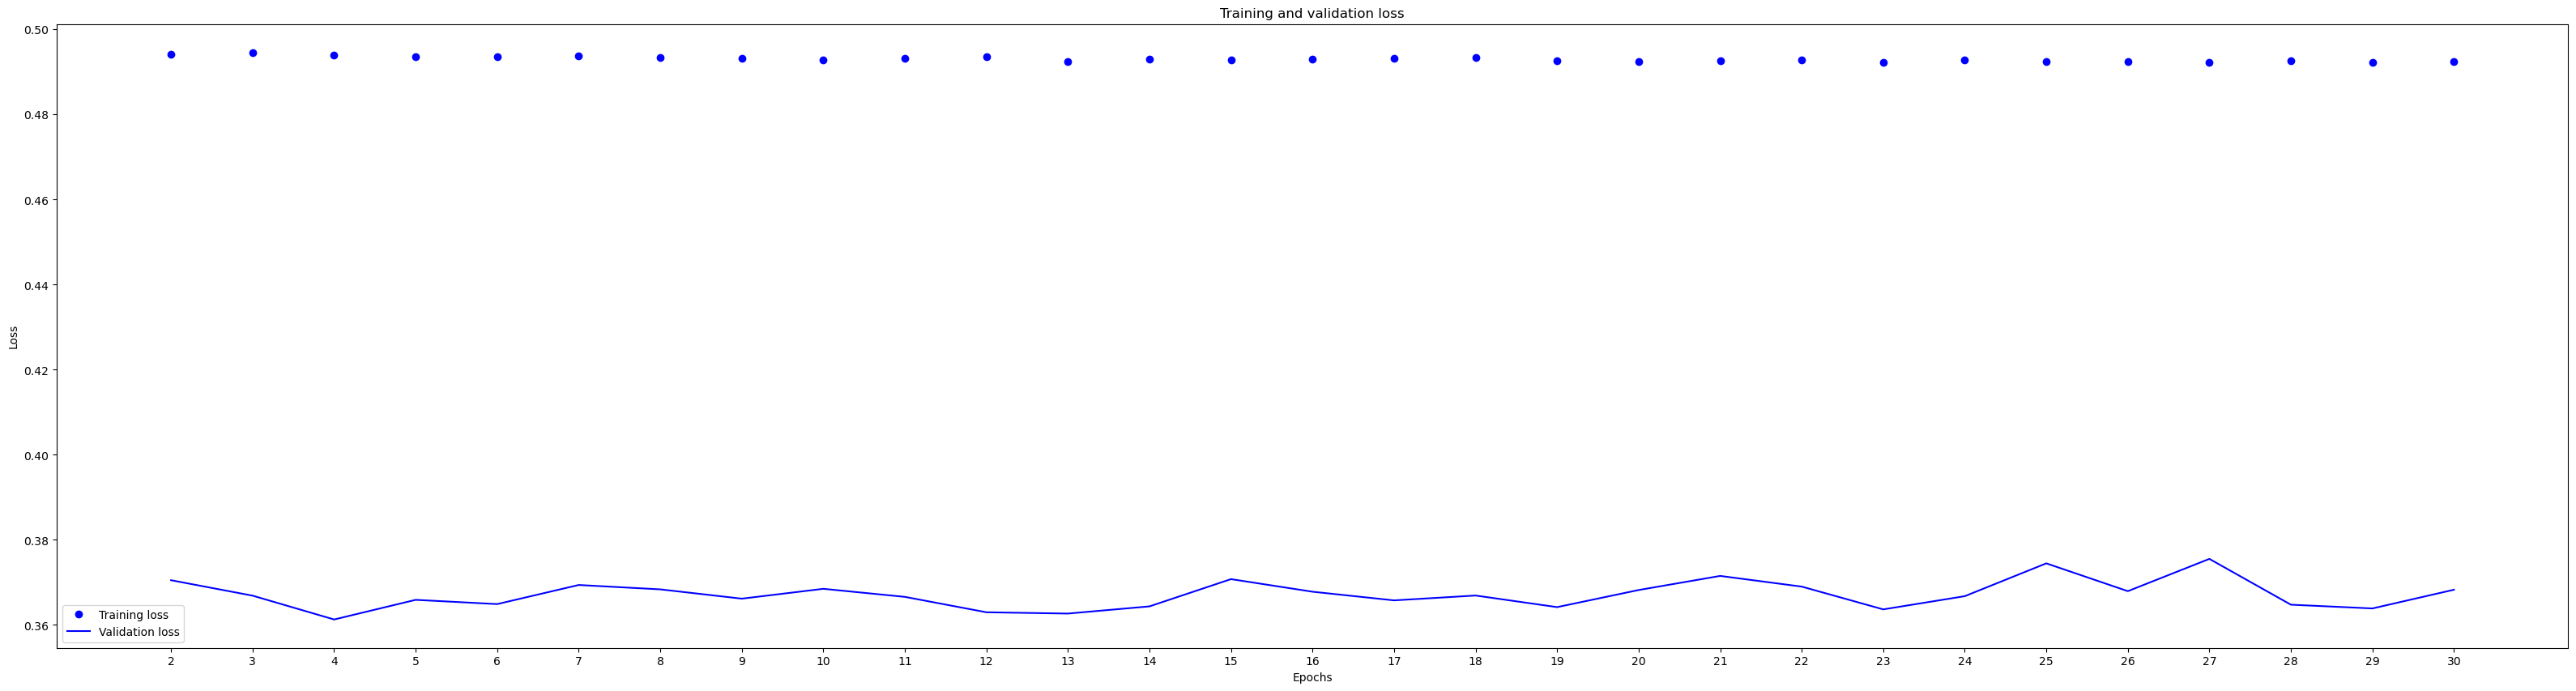

In [45]:
history_dict = history.history
loss_values = history_dict["loss"][1:]  # Skip the first epoch
val_loss_values = history_dict["val_loss"][1:]  # Skip the first epoch
epochs = range(2, len(loss_values) + 2)  # Start from the second epoch

plt.figure(figsize=(40,10))
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(min(epochs), max(epochs)+1, step=1)) # adjust the step size to change the compactness
plt.legend()
plt.show()

In [46]:
model_build()

In [ ]:
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [47]:
history = model.fit(x_train, y_train, epochs = 2, batch_size = 16, validation_data=(x_val, y_val))

Epoch 1/2
326/326 [==============================] - 1s 4ms/step - loss: 0.4917 - mae: 0.5607 - val_loss: 0.3652 - val_mae: 0.4343
Epoch 2/2
326/326 [==============================] - 1s 4ms/step - loss: 0.4929 - mae: 0.5611 - val_loss: 0.3645 - val_mae: 0.4398


In [52]:
results = model.evaluate(x_test, y_test)
results

51/51 [==============================] - 0s 3ms/step - loss: 0.5604 - mae: 0.5821


[0.5603728890419006, 0.5820673108100891]

In [53]:
predictions = model.predict(x_test)
predictions

51/51 [==============================] - 0s 2ms/step


array([[ 1.8278713 , -0.19600996, -0.19752844],
       [ 1.8278713 , -0.19600996, -0.19752844],
       [ 1.8278713 , -0.19600996, -0.19752844],
       ...,
       [ 1.4823353 , -0.27532682, -0.2764885 ],
       [ 1.4823353 , -0.27532682, -0.2764885 ],
       [ 1.4823353 , -0.27532682, -0.2764885 ]], dtype=float32)

In [55]:
predictions[:,:3]

array([[ 1.8278713 , -0.19600996, -0.19752844],
       [ 1.8278713 , -0.19600996, -0.19752844],
       [ 1.8278713 , -0.19600996, -0.19752844],
       ...,
       [ 1.4823353 , -0.27532682, -0.2764885 ],
       [ 1.4823353 , -0.27532682, -0.2764885 ],
       [ 1.4823353 , -0.27532682, -0.2764885 ]], dtype=float32)

In [56]:
AREA_CONGEST_LVL_pred = predictions[:,0]
AREA_CONGEST_LVL_y_test = y_test['AREA_CONGEST_LVL']

In [57]:
AREA_PPLTN_MIN_MAX_pred = scaler.inverse_transform(predictions[:,1:3])
AREA_PPLTN_MIN_pred = AREA_PPLTN_MIN_MAX_pred[:,0]
AREA_PPLTN_MAX_pred = AREA_PPLTN_MIN_MAX_pred[:,1]

In [58]:
AREA_PPLTN_MIN_MAX_y_test = scaler.inverse_transform(y_test[['AREA_PPLTN_MIN', 'AREA_PPLTN_MAX']])
AREA_PPLTN_MIN_y_test = AREA_PPLTN_MIN_MAX_y_test[:,0]
AREA_PPLTN_MAX_y_test = AREA_PPLTN_MIN_MAX_y_test[:,1]

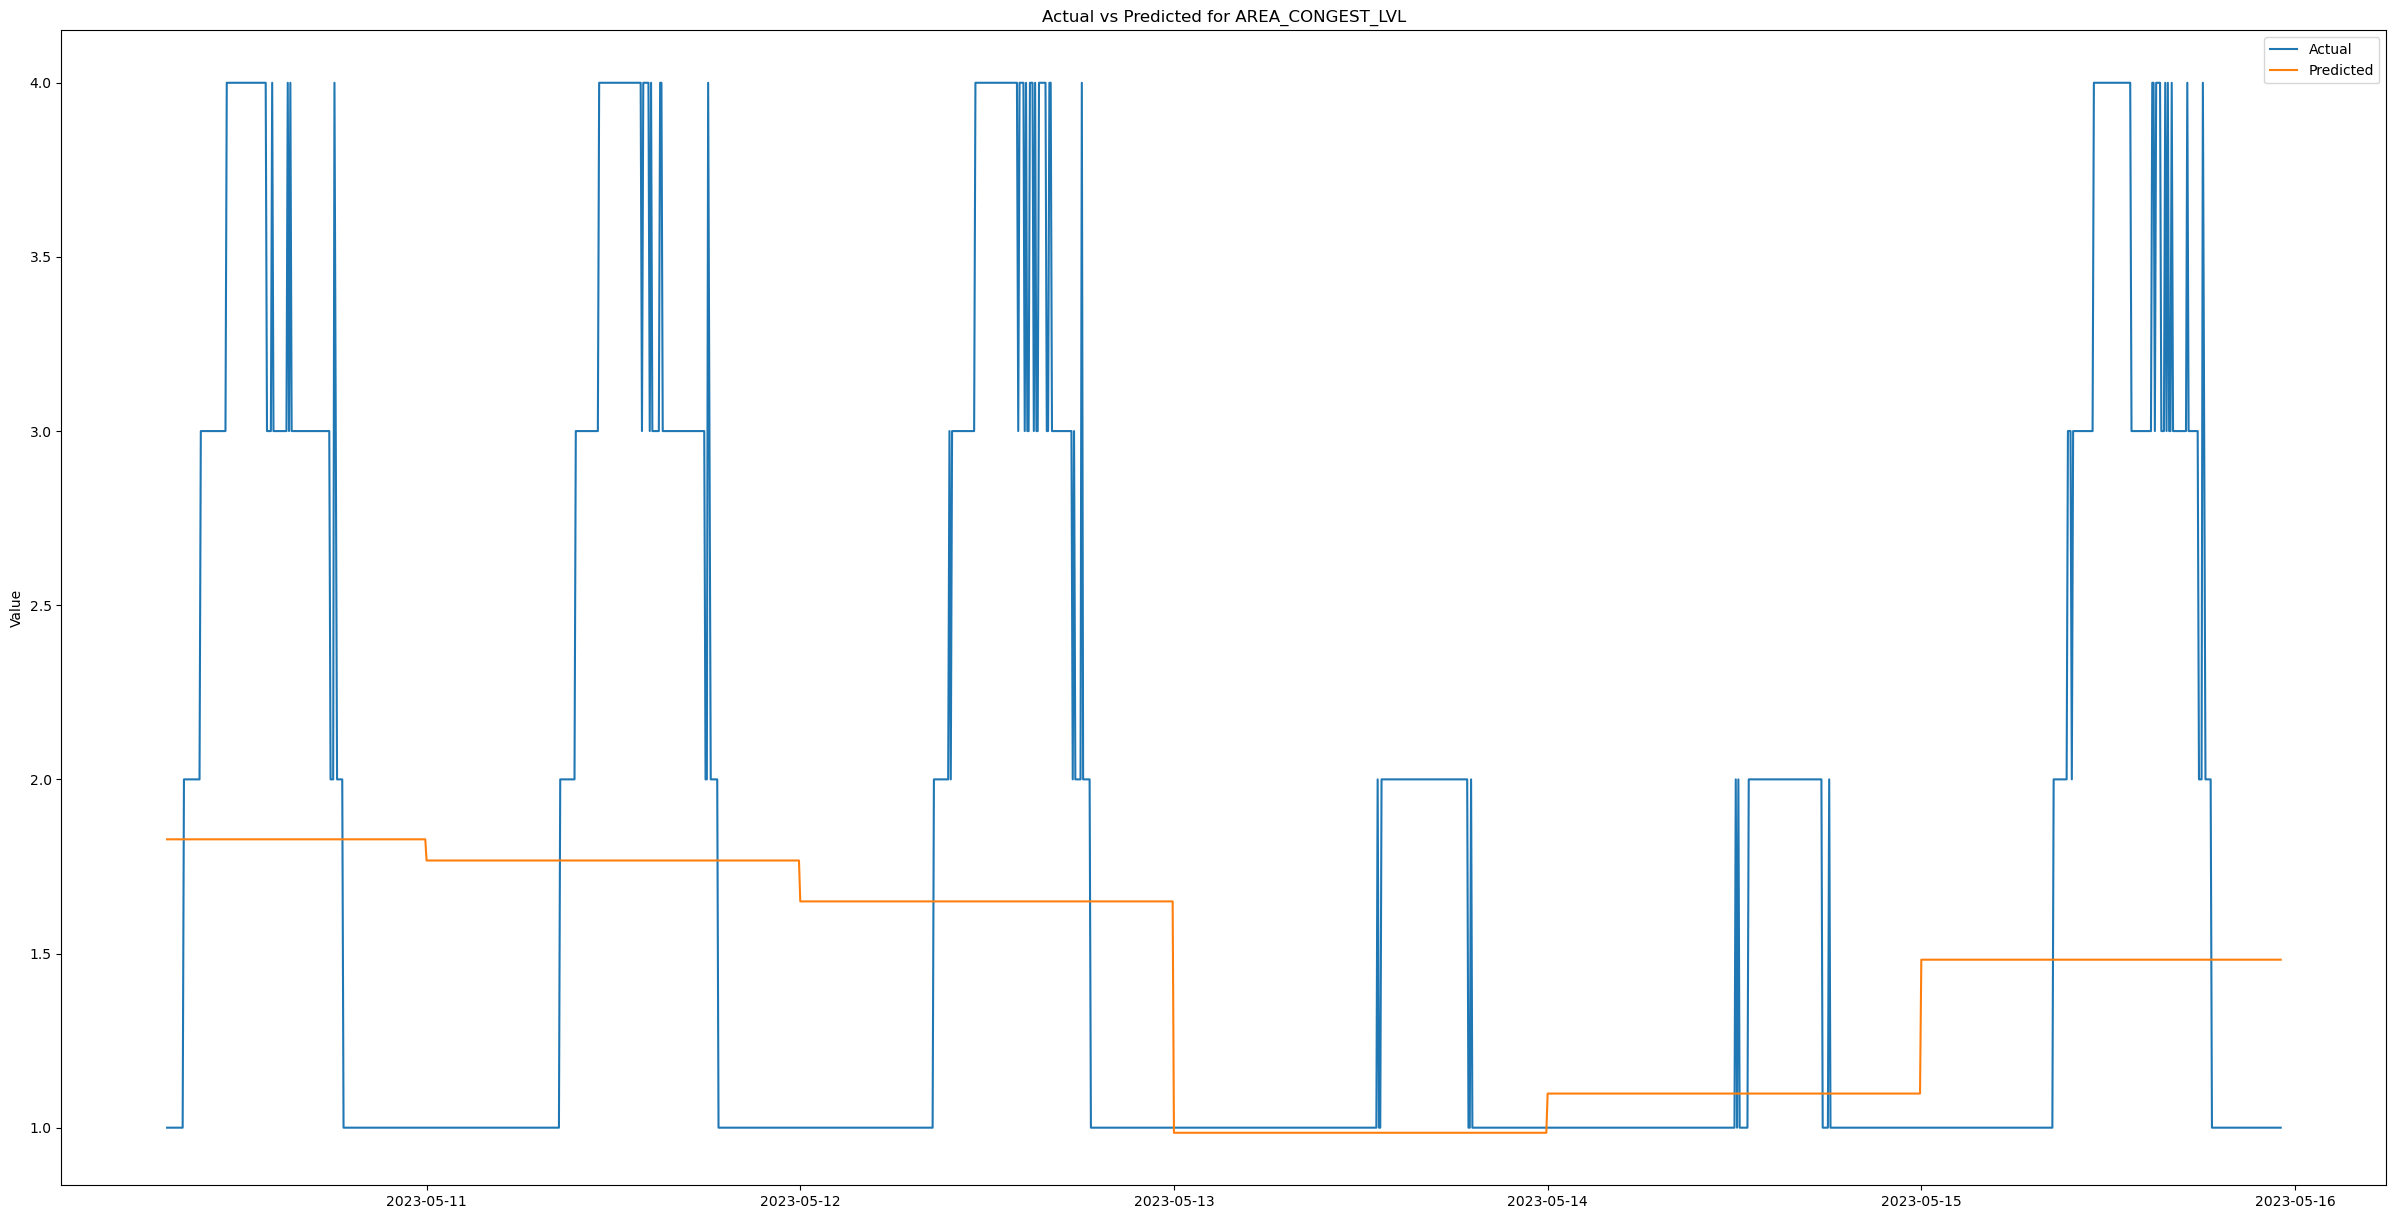

In [59]:
# Plot the actual and predicted values for AREA_CONGEST_LVL
plt.figure(figsize=(30,15))
plt.plot(y_test.index.values, AREA_CONGEST_LVL_y_test, label="Actual")
plt.plot(y_test.index.values, AREA_CONGEST_LVL_pred, label="Predicted")
plt.ylabel("Value")
plt.title("Actual vs Predicted for AREA_CONGEST_LVL")
plt.legend()
plt.show()

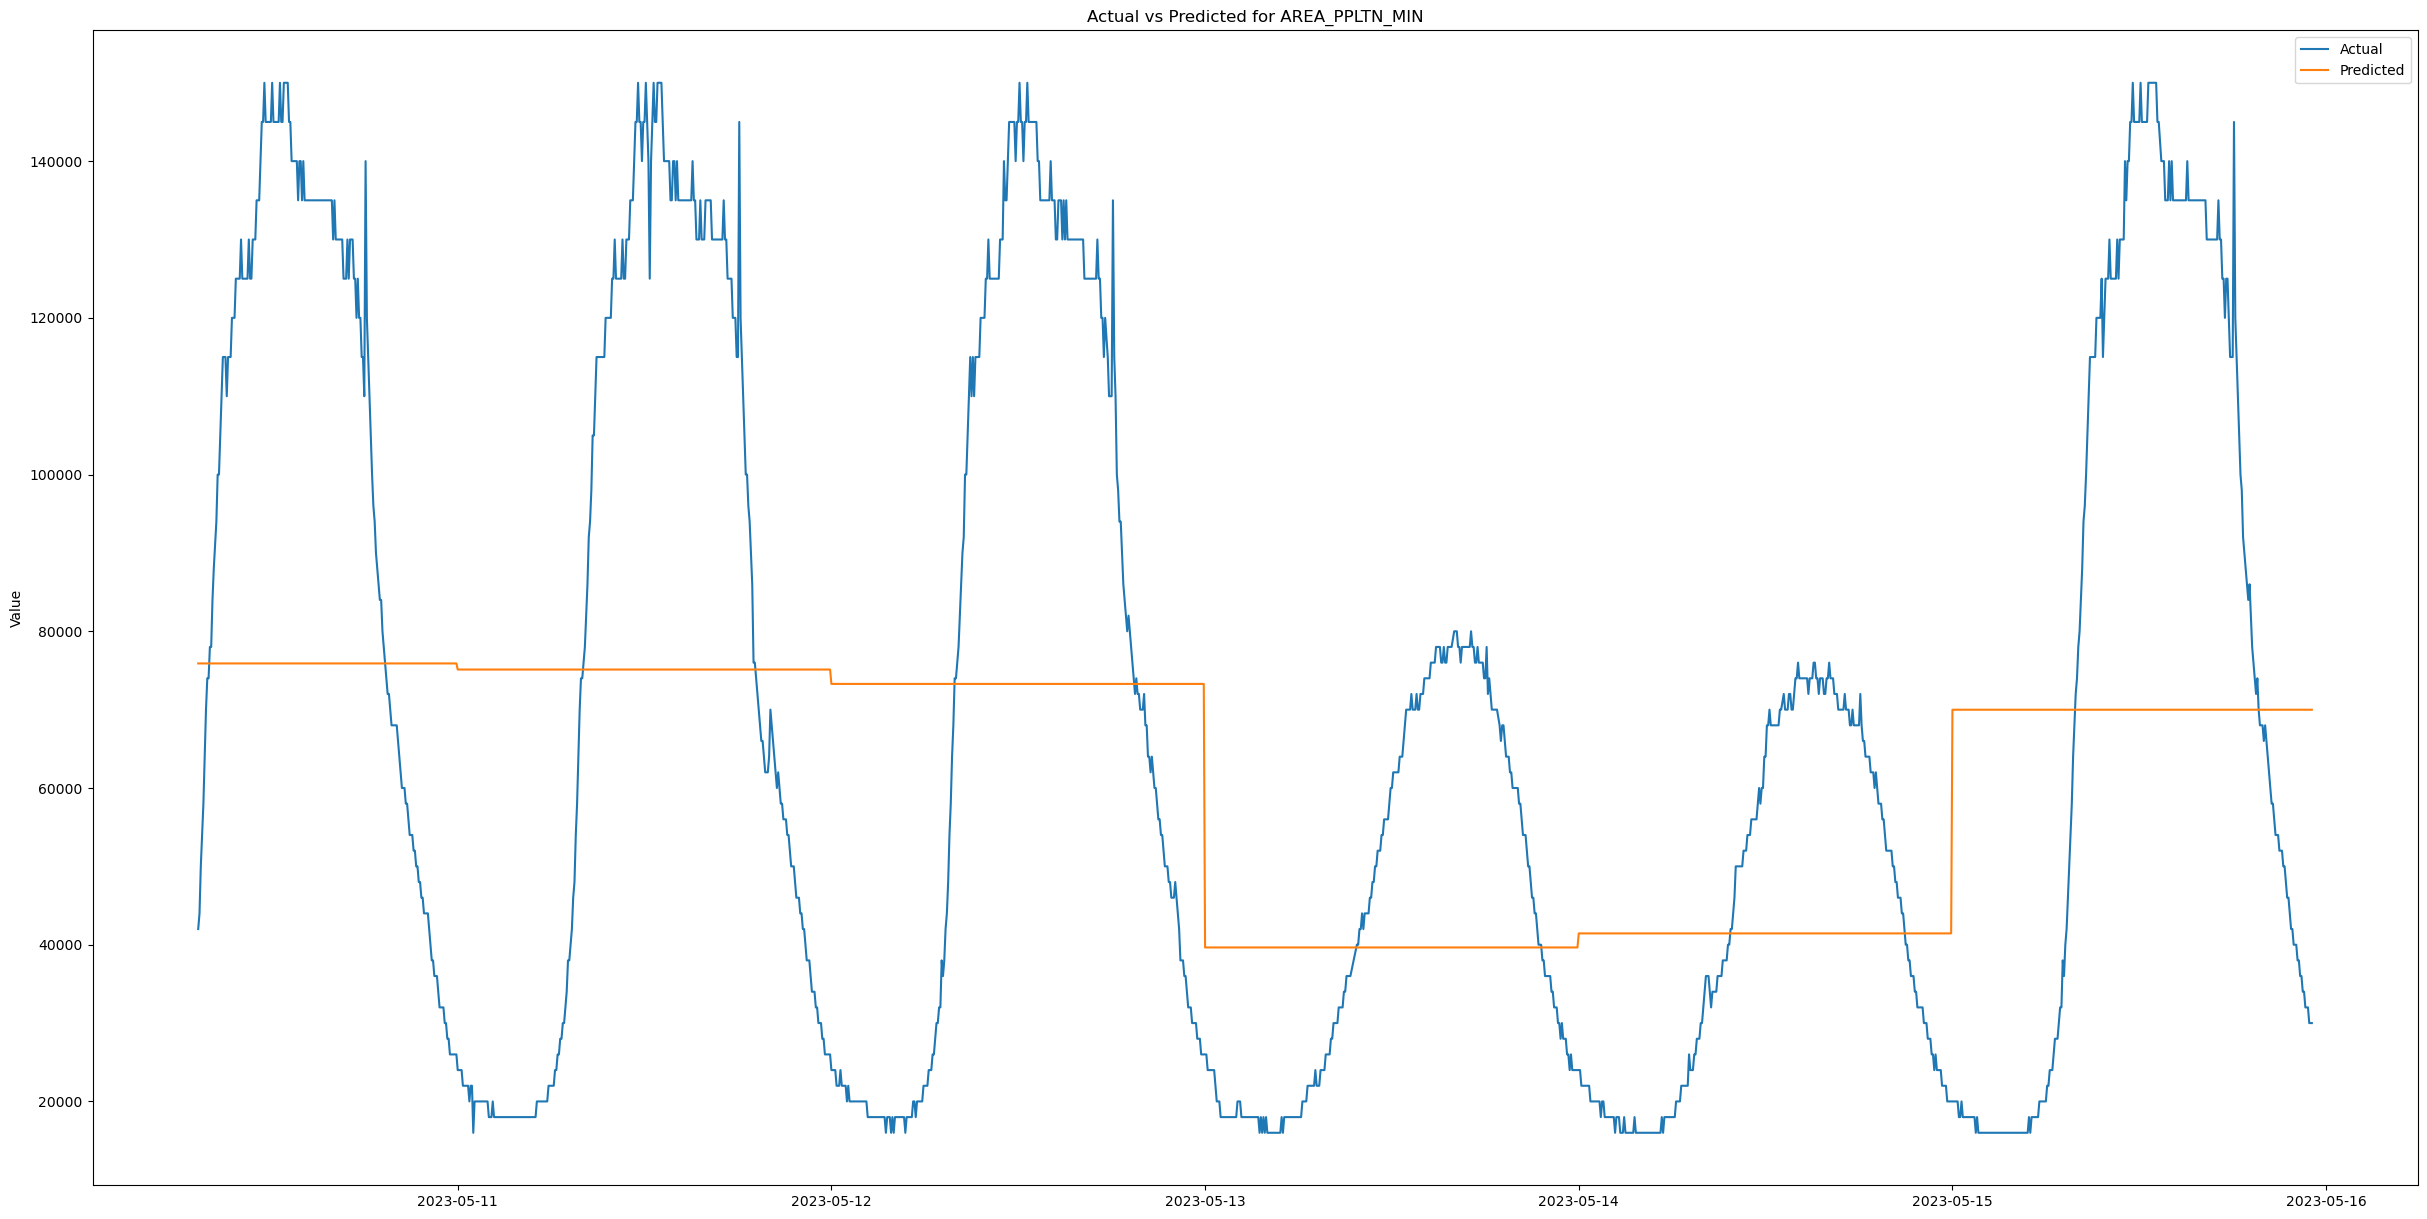

In [60]:
# Plot the actual and predicted values for AREA_CONGEST_LVL
plt.figure(figsize=(30,15))
plt.plot(y_test.index.values, AREA_PPLTN_MIN_y_test, label="Actual")
plt.plot(y_test.index.values, AREA_PPLTN_MIN_pred, label="Predicted")
plt.ylabel("Value")
plt.title("Actual vs Predicted for AREA_PPLTN_MIN")
plt.legend()
plt.show()

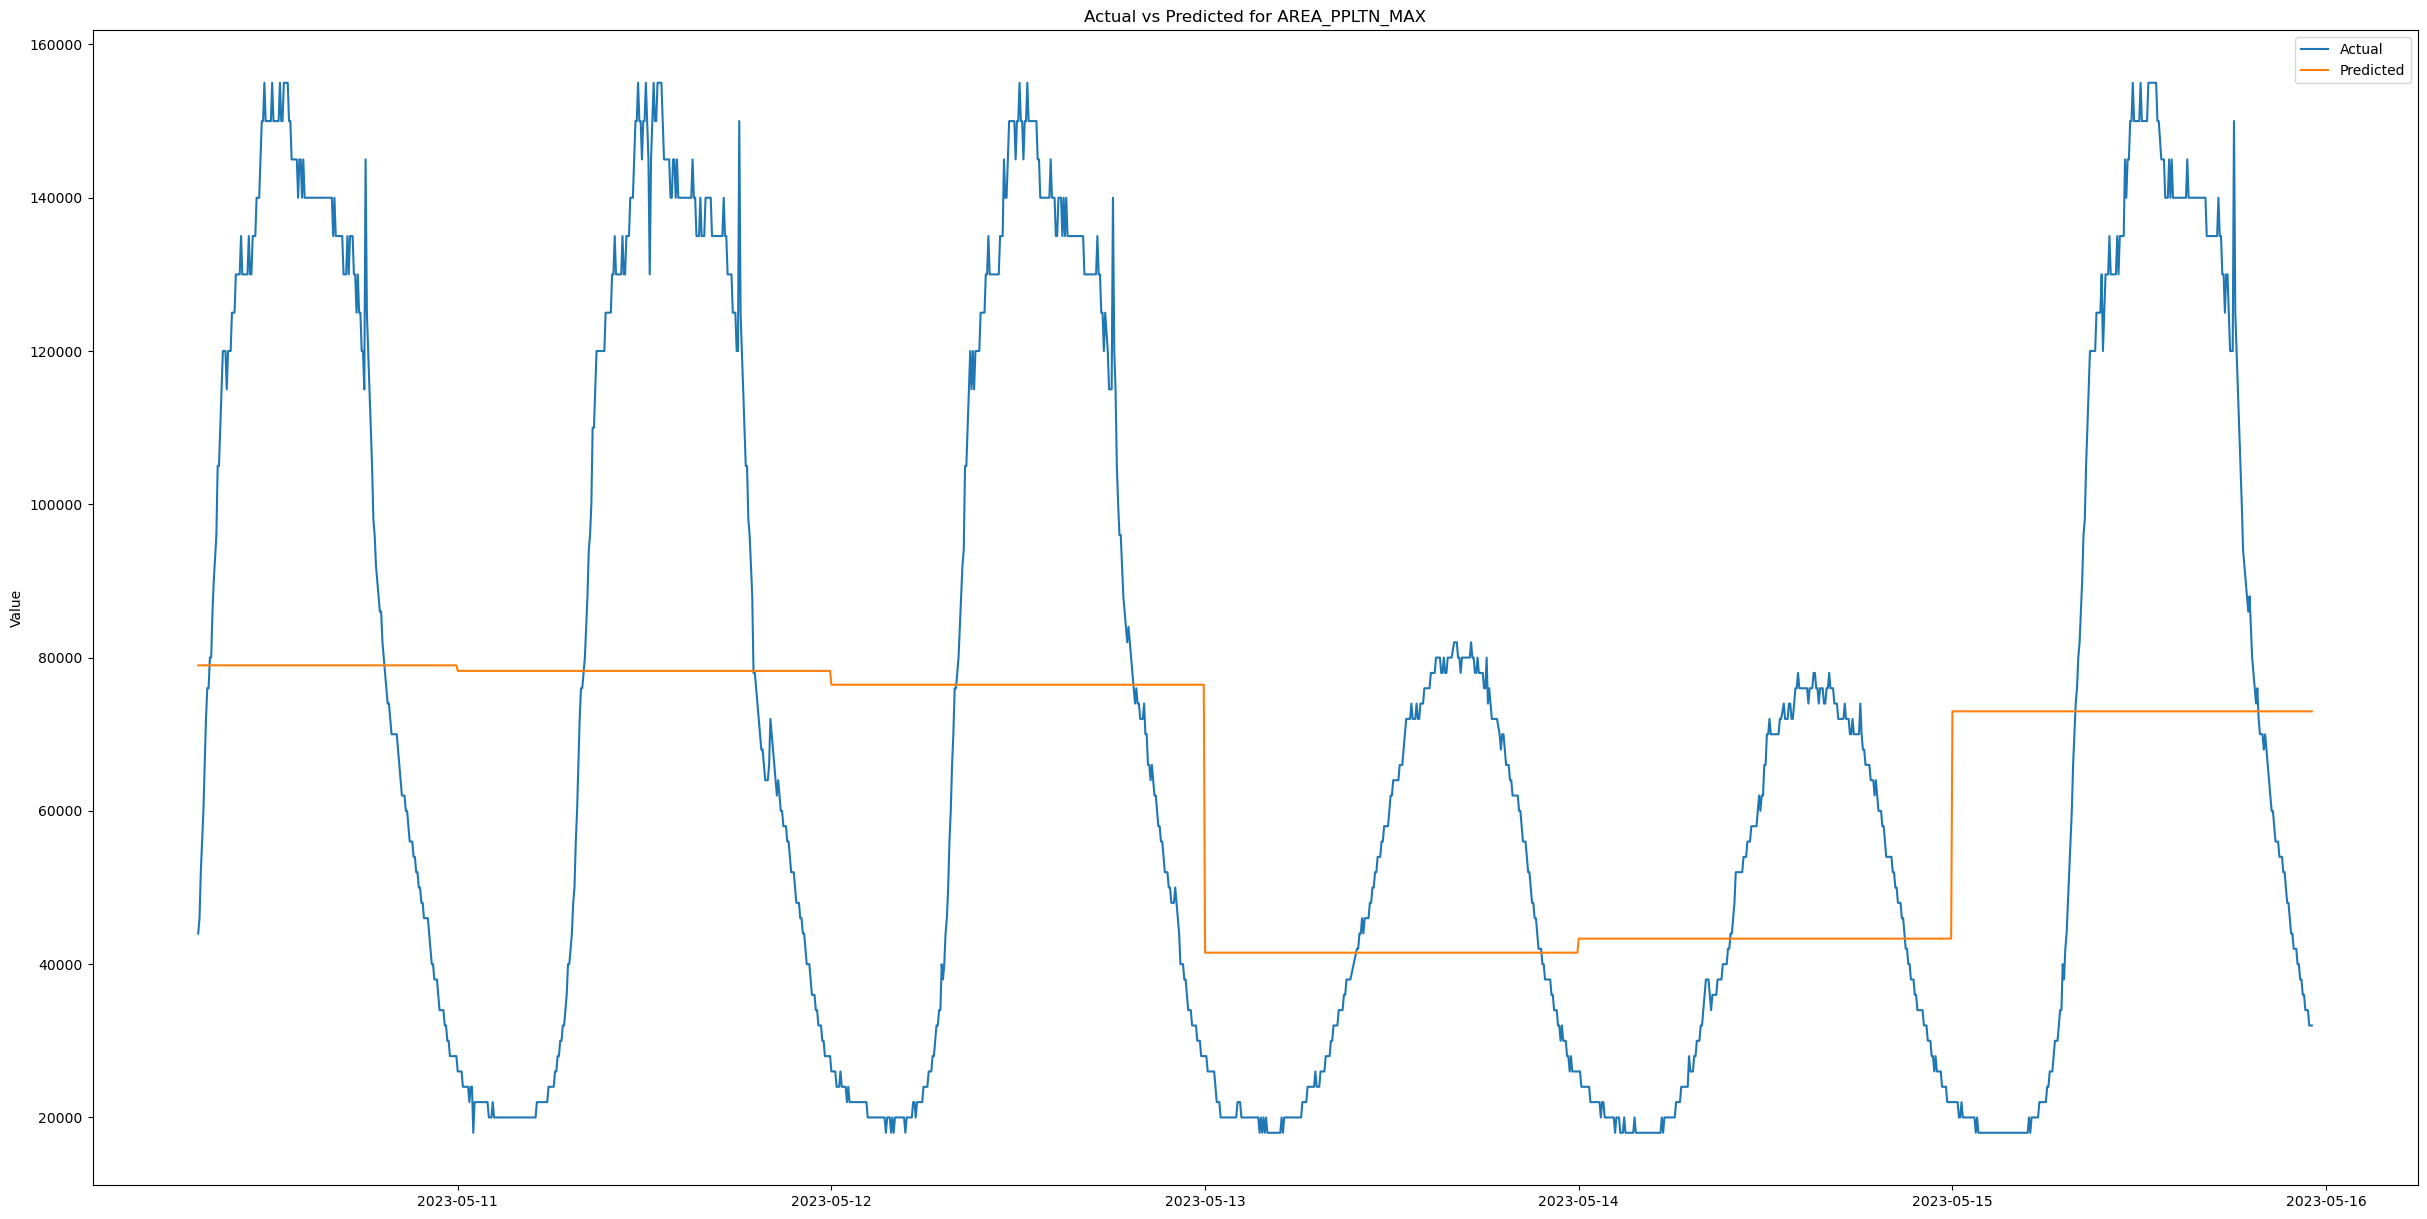

In [61]:
# Plot the actual and predicted values for AREA_CONGEST_LVL
plt.figure(figsize=(30,15))
plt.plot(y_test.index.values, AREA_PPLTN_MAX_y_test, label="Actual")
plt.plot(y_test.index.values, AREA_PPLTN_MAX_pred, label="Predicted")
plt.ylabel("Value")
plt.title("Actual vs Predicted for AREA_PPLTN_MAX")
plt.legend()
plt.show()